In [125]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings("ignore")

sp500 = pd.read_html(
        "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",
        attrs={"id": "constituents"},
        header=0,
        storage_options={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"},
    )[0]

sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-")

symbols_list = sp500["Symbol"].unique().tolist()

end_date = '2025-12-29'

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

[*********************100%***********************]  503 of 503 completed


In [126]:
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

Price                   close        high         low        open       volume
date       ticker                                                             
2018-01-02 A        63.781506   64.055125   63.536190   63.611673    1047800.0
           AAPL     40.341881   40.351250   39.639305   39.850080  102223600.0
           ABBV     69.901634   70.249685   68.722517   68.999537    4561300.0
           ABT      51.080383   51.436616   50.237586   50.567755   10112800.0
           ACGL     27.988113   28.926334   27.940569   28.910486    1333500.0
...                       ...         ...         ...         ...          ...
2025-12-26 XYZ      66.269997   66.470001   65.339996   65.875000    3118400.0
           YUM     153.240005  154.470001  152.759995  154.199997    1086400.0
           ZBH      90.529366   90.788678   89.621782   89.911014     967500.0
           ZBRA    246.270004  246.550003  243.690002  245.899994     622400.0
           ZTS     126.230003  126.320000  124.800003  125.160004    3226800.0

[988762 rows x 5 columns]

In [127]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-((2*np.log(2)-1)*(np.log(df['close'])-np.log(df['open'])))**2

df['rsi'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df['bb_mid'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])

df['bb_high'] = df.groupby(level=1)['close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)

    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, slow=20).iloc[:, 0]

    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['close'].apply(compute_macd)

df['dollar_volume'] = (df['close']*df['volume'])/1e6

df

Price                   close        high         low        open  \
date       ticker                                                   
2018-01-02 A        63.781506   64.055125   63.536190   63.611673   
           AAPL     40.341881   40.351250   39.639305   39.850080   
           ABBV     69.901634   70.249685   68.722517   68.999537   
           ABT      51.080383   51.436616   50.237586   50.567755   
           ACGL     27.988113   28.926334   27.940569   28.910486   
...                       ...         ...         ...         ...   
2025-12-26 XYZ      66.269997   66.470001   65.339996   65.875000   
           YUM     153.240005  154.470001  152.759995  154.199997   
           ZBH      90.529366   90.788678   89.621782   89.911014   
           ZBRA    246.270004  246.550003  243.690002  245.899994   
           ZTS     126.230003  126.320000  124.800003  125.160004   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2018-01-02 A         1047800.0          0.000032        NaN       NaN   
           AAPL    102223600.0          0.000136        NaN       NaN   
           ABBV      4561300.0          0.000216        NaN       NaN   
           ABT      10112800.0          0.000263        NaN       NaN   
           ACGL      1333500.0          0.000444        NaN       NaN   
...                        ...               ...        ...       ...   
2025-12-26 XYZ       3118400.0          0.000142  50.969311  4.109469   
           YUM       1086400.0          0.000056  55.865589  4.960961   
           ZBH        967500.0          0.000077  44.639561  4.487917   
           ZBRA       622400.0          0.000068  39.860392  5.489928   
           ZTS       3226800.0          0.000062  51.243072  4.756083   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2018-01-02 A            NaN       NaN       NaN       NaN      66.830262  
           AAPL         NaN       NaN       NaN       NaN    4123.892286  
           ABBV         NaN       NaN       NaN       NaN     318.842324  
           ABT          NaN       NaN       NaN       NaN     516.565700  
           ACGL         NaN       NaN       NaN       NaN      37.322149  
...                     ...       ...       ...       ...            ...  
2025-12-26 XYZ     4.169642  4.229814 -0.816603  0.044355     206.656358  
           YUM     5.017504  5.074046  1.059851  1.057652     166.479942  
           ZBH     4.531769  4.575621 -0.833503 -0.429069      87.587161  
           ZBRA    5.556473  5.623019 -0.587094 -0.419918     153.278451  
           ZTS     4.811936  4.867789 -0.346556  0.005031     407.318975  

[988762 rows x 13 columns]

In [128]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'adj close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1))

data

dollar_volume       close  garman_klass_vol        rsi  \
date       ticker                                                           
2018-01-31 A          124.699607   69.282196          0.000118  86.770621   
           AAPL      5107.318595   39.210743          0.000065  31.631046   
           ABBV       531.232804   80.282784          0.000864  71.626211   
           ABT        391.374520   54.266739          0.000097  73.750105   
           ACGL        46.003407   28.824903          0.000052  58.550097   
...                          ...         ...               ...        ...   
2025-12-31 XYZ        448.245911   66.269997          0.000142  50.969311   
           YUM        336.246667  153.240005          0.000056  55.865589   
           ZBH        200.009521   90.529366          0.000077  44.639561   
           ZBRA       146.673049  246.270004          0.000068  39.860392   
           ZTS        776.201837  126.230003          0.000062  51.243072   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2018-01-31 A       4.186225  4.234121  4.282017 -1.616198  0.625427  
           AAPL    3.690543  3.732000  3.773457 -1.505386 -0.548271  
           ABBV    4.199333  4.334643  4.469953  0.057870  2.372864  
           ABT     3.916943  3.977255  4.037567 -1.466632  1.133875  
           ACGL    3.346834  3.389321  3.431807 -1.084494  0.217823  
...                     ...       ...       ...       ...       ...  
2025-12-31 XYZ     4.109469  4.169642  4.229814 -0.816603  0.044355  
           YUM     4.960961  5.017504  5.074046  1.059851  1.057652  
           ZBH     4.487917  4.531769  4.575621 -0.833503 -0.429069  
           ZBRA    5.489928  5.556473  5.623019 -0.587094 -0.419918  
           ZTS     4.756083  4.811936  4.867789 -0.346556  0.005031  

[47286 rows x 9 columns]

In [129]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data = data.dropna(subset=['dollar_volume'])

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-12-31 AAPL     37.496033          0.000163  37.072860  3.577747   
           ABBV     68.037064          0.000176  57.957395  4.116700   
           ABT      63.996532          0.000141  55.190186  4.091732   
           ACN     127.567741          0.000089  36.633897  4.790105   
           ADBE    226.240005          0.000163  46.330496  5.325858   
...                       ...               ...        ...       ...   
2025-12-31 WDAY    220.699997          0.000194  48.359114  5.358038   
           WFC      95.260002          0.000031  69.240305  4.458383   
           WMT     111.739998          0.000015  54.037018  4.708631   
           XOM     119.110001          0.000036  56.052996  4.750221   
           XYZ      66.269997          0.000142  50.969311  4.109469   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-12-31 AAPL    3.692733  3.807720 -1.023400 -0.982662  
           ABBV    4.189424  4.262148 -0.204423 -0.047184  
           ABT     4.150959  4.210185 -0.176682 -0.267787  
           ACN     4.926166  5.062227 -0.581459 -1.211768  
           ADBE    5.452557  5.579255 -0.310498 -0.616175  
...                     ...       ...       ...       ...  
2025-12-31 WDAY    5.389565  5.421092 -0.756124 -0.408540  
           WFC     4.523156  4.587929  1.269698  2.174693  
           WMT     4.742372  4.776112  2.106048  1.055115  
           XOM     4.775059  4.799897  0.433280  0.380200  
           XYZ     4.169642  4.229814 -0.816603  0.044355  

[12665 rows x 8 columns]

In [130]:
def calculate_returns (df):
    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                                                upper=x.quantile(1 - outlier_cutoff))).add(1).pow(1/lag).sub(1))
        
    return df    

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data
                                                            

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-12-31 AAPL     70.851692          0.000078  77.551229  4.145370   
           ABBV     69.035957          0.000031  58.451489  4.215296   
           ABT      78.127090          0.000032  58.088815  4.336947   
           ACN     192.899796          0.000029  68.147341  5.200360   
           ADBE    329.809998          0.000046  72.249838  5.690995   
...                       ...               ...        ...       ...   
2025-12-31 WDAY    220.699997          0.000194  48.359114  5.358038   
           WFC      95.260002          0.000031  69.240305  4.458383   
           WMT     111.739998          0.000015  54.037018  4.708631   
           XOM     119.110001          0.000036  56.052996  4.750221   
           XYZ      66.269997          0.000142  50.969311  4.109469   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-12-31 AAPL    4.216973  4.288577 -1.240065  0.419416   0.098784   
           ABBV    4.246336  4.277376 -1.233183  0.067929   0.009233   
           ABT     4.363037  4.389128 -1.426314  0.302922   0.016501   
           ACN     5.245035  5.289710 -1.330750  0.636488   0.046779   
           ADBE    5.764480  5.837965 -1.575032  0.791894   0.065519   
...                     ...       ...       ...       ...        ...   
2025-12-31 WDAY    5.389565  5.421092 -0.756124 -0.408540   0.023560   
           WFC     4.523156  4.587929  1.269698  2.174693   0.109610   
           WMT     4.742372  4.776112  2.106048  1.055115   0.013191   
           XOM     4.775059  4.799897  0.433280  0.380200   0.027519   
           XYZ     4.169642  4.229814 -0.816603  0.044355  -0.007934   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-12-31 AAPL     0.088117   0.095588   0.069174   0.050835    0.054461  
           ABBV     0.054993   0.058616   0.038463   0.015323    0.001215  
           ABT      0.019250   0.013902   0.006694   0.010594    0.016765  
           ACN      0.065663   0.032101   0.022754   0.021535    0.035061  
           ADBE     0.089342   0.060850   0.018966   0.023969    0.031909  
...                      ...        ...        ...        ...         ...  
2025-12-31 WDAY    -0.040891  -0.028542  -0.013875  -0.006259   -0.012938  
           WFC      0.049323   0.045394   0.031174   0.033830    0.027555  
           WMT      0.051960   0.028019   0.023237   0.027940    0.018673  
           XOM      0.025010   0.021421   0.019817   0.003189    0.011562  
           XYZ     -0.065836  -0.028477  -0.004115   0.022319   -0.020520  

[10428 rows x 14 columns]

In [131]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

# Unir los factores con data manteniendo el índice multinivel
factor_data = (data['return_1m']
               .reset_index()
               .merge(factor_data, left_on='date', right_index=True)
               .set_index(['date', 'ticker']))

factor_data

return_1m  Mkt-RF     SMB     HML     RMW     CMA
date       ticker                                                   
2019-12-31 AAPL     0.098784  0.0276  0.0099  0.0173  0.0005  0.0119
           ABBV     0.009233  0.0276  0.0099  0.0173  0.0005  0.0119
           ABT      0.016501  0.0276  0.0099  0.0173  0.0005  0.0119
           ACN      0.046779  0.0276  0.0099  0.0173  0.0005  0.0119
           ADBE     0.065519  0.0276  0.0099  0.0173  0.0005  0.0119
...                      ...     ...     ...     ...     ...     ...
2025-11-30 WDAY    -0.101284 -0.0013  0.0147  0.0376  0.0143  0.0068
           WFC     -0.007688 -0.0013  0.0147  0.0376  0.0143  0.0068
           WMT      0.092212 -0.0013  0.0147  0.0376  0.0143  0.0068
           XOM      0.022507 -0.0013  0.0147  0.0376  0.0143  0.0068
           XYZ     -0.120358 -0.0013  0.0147  0.0376  0.0143  0.0068

[10288 rows x 6 columns]

In [132]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

return_1m  Mkt-RF     SMB     HML     RMW     CMA
date       ticker                                                   
2019-12-31 AAPL     0.098784  0.0276  0.0099  0.0173  0.0005  0.0119
           ABBV     0.009233  0.0276  0.0099  0.0173  0.0005  0.0119
           ABT      0.016501  0.0276  0.0099  0.0173  0.0005  0.0119
           ACN      0.046779  0.0276  0.0099  0.0173  0.0005  0.0119
           ADBE     0.065519  0.0276  0.0099  0.0173  0.0005  0.0119
...                      ...     ...     ...     ...     ...     ...
2025-11-30 WDAY    -0.101284 -0.0013  0.0147  0.0376  0.0143  0.0068
           WFC     -0.007688 -0.0013  0.0147  0.0376  0.0143  0.0068
           WMT      0.092212 -0.0013  0.0147  0.0376  0.0143  0.0068
           XOM      0.022507 -0.0013  0.0147  0.0376  0.0143  0.0068
           XYZ     -0.120358 -0.0013  0.0147  0.0376  0.0143  0.0068

[10235 rows x 6 columns]

In [133]:
betas = (factor_data.groupby(level=1, group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                    exog=sm.add_constant(x.drop('return_1m', axis=1)), 
                                    window=min(24, x.shape[0]),
                                    min_nobs=len(x.columns)+1)
                                    .fit(params_only=True)
                                    .params
                                    .drop('const', axis=1)))

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data

close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-12-31 AAPL     70.851692          0.000078  77.551229  4.145370   
           ABBV     69.035957          0.000031  58.451489  4.215296   
           ABT      78.127090          0.000032  58.088815  4.336947   
           ACN     192.899796          0.000029  68.147341  5.200360   
           ADBE    329.809998          0.000046  72.249838  5.690995   
...                       ...               ...        ...       ...   
2025-12-31 WDAY    220.699997          0.000194  48.359114  5.358038   
           WFC      95.260002          0.000031  69.240305  4.458383   
           WMT     111.739998          0.000015  54.037018  4.708631   
           XOM     119.110001          0.000036  56.052996  4.750221   
           XYZ      66.269997          0.000142  50.969311  4.109469   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-12-31 AAPL    4.216973  4.288577 -1.240065  0.419416   0.098784   
           ABBV    4.246336  4.277376 -1.233183  0.067929   0.009233   
           ABT     4.363037  4.389128 -1.426314  0.302922   0.016501   
           ACN     5.245035  5.289710 -1.330750  0.636488   0.046779   
           ADBE    5.764480  5.837965 -1.575032  0.791894   0.065519   
...                     ...       ...       ...       ...        ...   
2025-12-31 WDAY    5.389565  5.421092 -0.756124 -0.408540   0.023560   
           WFC     4.523156  4.587929  1.269698  2.174693   0.109610   
           WMT     4.742372  4.776112  2.106048  1.055115   0.013191   
           XOM     4.775059  4.799897  0.433280  0.380200   0.027519   
           XYZ     4.169642  4.229814 -0.816603  0.044355  -0.007934   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2019-12-31 AAPL     0.088117   0.095588   0.069174   0.050835    0.054461   
           ABBV     0.054993   0.058616   0.038463   0.015323    0.001215   
           ABT      0.019250   0.013902   0.006694   0.010594    0.016765   
           ACN      0.065663   0.032101   0.022754   0.021535    0.035061   
           ADBE     0.089342   0.060850   0.018966   0.023969    0.031909   
...                      ...        ...        ...        ...         ...   
2025-12-31 WDAY    -0.040891  -0.028542  -0.013875  -0.006259   -0.012938   
           WFC      0.049323   0.045394   0.031174   0.033830    0.027555   
           WMT      0.051960   0.028019   0.023237   0.027940    0.018673   
           XOM      0.025010   0.021421   0.019817   0.003189    0.011562   
           XYZ     -0.065836  -0.028477  -0.004115   0.022319   -0.020520   

                   Mkt-RF  SMB  HML  RMW  CMA  
date       ticker                              
2019-12-31 AAPL       NaN  NaN  NaN  NaN  NaN  
           ABBV       NaN  NaN  NaN  NaN  NaN  
           ABT        NaN  NaN  NaN  NaN  NaN  
           ACN        NaN  NaN  NaN  NaN  NaN  
           ADBE       NaN  NaN  NaN  NaN  NaN  
...                   ...  ...  ...  ...  ...  
2025-12-31 WDAY       NaN  NaN  NaN  NaN  NaN  
           WFC        NaN  NaN  NaN  NaN  NaN  
           WMT        NaN  NaN  NaN  NaN  NaN  
           XOM        NaN  NaN  NaN  NaN  NaN  
           XYZ        NaN  NaN  NaN  NaN  NaN  

[10428 rows x 19 columns]

In [134]:
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.dropna()

data = data.drop('close', axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10159 entries, (Timestamp('2019-12-31 00:00:00'), 'AAPL') to (Timestamp('2025-12-31 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10159 non-null  float64
 1   rsi               10159 non-null  float64
 2   bb_low            10159 non-null  float64
 3   bb_mid            10159 non-null  float64
 4   bb_high           10159 non-null  float64
 5   atr               10159 non-null  float64
 6   macd              10159 non-null  float64
 7   return_1m         10159 non-null  float64
 8   return_2m         10159 non-null  float64
 9   return_3m         10159 non-null  float64
 10  return_6m         10159 non-null  float64
 11  return_9m         10159 non-null  float64
 12  return_12m        10159 non-null  float64
 13  Mkt-RF            10159 non-null  float64
 14  SMB               10159 non-null  float64
 15  HML       

In [135]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, 
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-12-31 AAPL            0.000078  77.551229  4.145370  4.216973  4.288577   
           ABBV            0.000031  58.451489  4.215296  4.246336  4.277376   
           ABT             0.000032  58.088815  4.336947  4.363037  4.389128   
           ACN             0.000029  68.147341  5.200360  5.245035  5.289710   
           ADBE            0.000046  72.249838  5.690995  5.764480  5.837965   
...                             ...        ...       ...       ...       ...   
2025-12-31 WDAY            0.000194  48.359114  5.358038  5.389565  5.421092   
           WFC             0.000031  69.240305  4.458383  4.523156  4.587929   
           WMT             0.000015  54.037018  4.708631  4.742372  4.776112   
           XOM             0.000036  56.052996  4.750221  4.775059  4.799897   
           XYZ             0.000142  50.969311  4.109469  4.169642  4.229814   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-12-31 AAPL   -1.240065  0.419416   0.098784   0.088117   0.095588   
           ABBV   -1.233183  0.067929   0.009233   0.054993   0.058616   
           ABT    -1.426314  0.302922   0.016501   0.019250   0.013902   
           ACN    -1.330750  0.636488   0.046779   0.065663   0.032101   
           ADBE   -1.575032  0.791894   0.065519   0.089342   0.060850   
...                     ...       ...        ...        ...        ...   
2025-12-31 WDAY   -0.756124 -0.408540   0.023560  -0.040891  -0.028542   
           WFC     1.269698  2.174693   0.109610   0.049323   0.045394   
           WMT     2.106048  1.055115   0.013191   0.051960   0.028019   
           XOM     0.433280  0.380200   0.027519   0.025010   0.021421   
           XYZ    -0.816603  0.044355  -0.007934  -0.065836  -0.028477   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-12-31 AAPL     0.069174   0.050835    0.054461  1.130685  0.022464   
           ABBV     0.038463   0.015323    0.001215  0.519053 -0.079123   
           ABT      0.006694   0.010594    0.016765  0.788474 -0.135549   
           ACN      0.022754   0.021535    0.035061  1.132992 -0.154898   
           ADBE     0.018966   0.023969    0.031909  1.485566 -0.740056   
...                      ...        ...         ...       ...       ...   
2025-12-31 WDAY    -0.013875  -0.006259   -0.012938  1.162466 -0.705090   
           WFC      0.031174   0.033830    0.027555  1.045540 -0.115183   
           WMT      0.023237   0.027940    0.018673  0.675755 -0.207638   
           XOM      0.019817   0.003189    0.011562  0.823794 -0.226474   
           XYZ     -0.004115   0.022319   -0.020520  2.428745  0.408189   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-12-31 AAPL   -0.573565  0.487613  0.202798        3  
           ABBV    0.130313  0.194028  0.722531        2  
           ABT    -0.142589 -0.080033  0.823776        2  
           ACN    -0.195944  0.092420 -0.152091        3  
           ADBE   -0.063641  0.300219 -0.423581        3  
...                     ...       ...       ...      ...  
2025-12-31 WDAY   -0.185265 -1.060307 -0.427329        1  
           WFC     1.442738 -0.910264 -0.956252        3  
           WMT    -0.340646  0.256249  0.291749        2  
           XOM     0.992032 -0.186081  0.334006        2  
           XYZ    -0.049562 -2.572047 -0.069261        1  

[10159 rows x 19 columns]

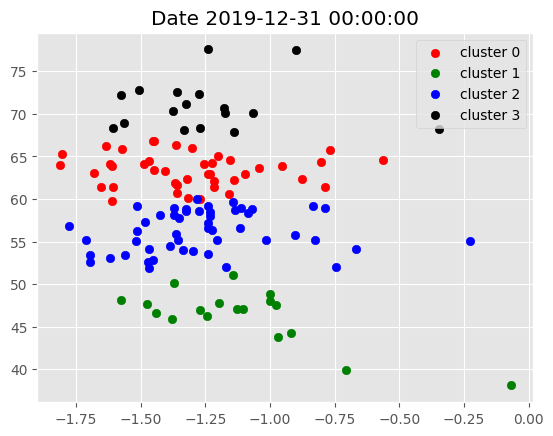

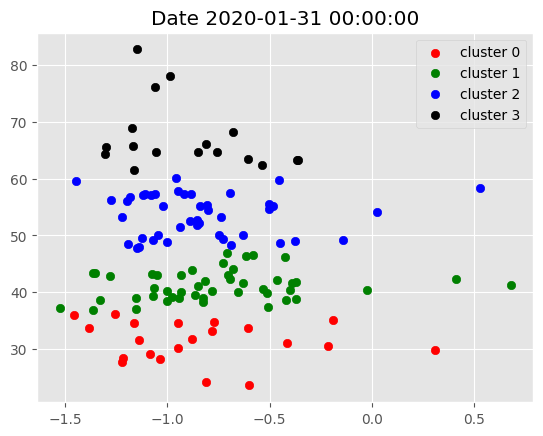

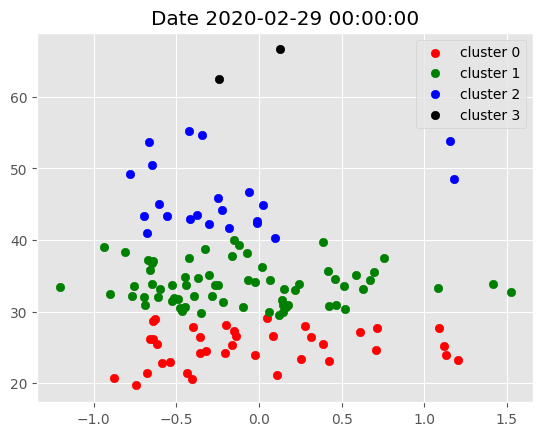

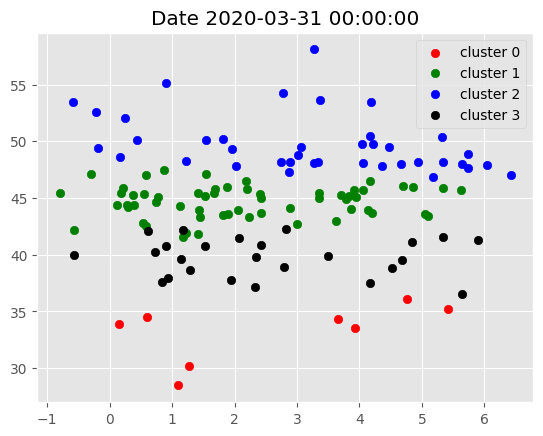

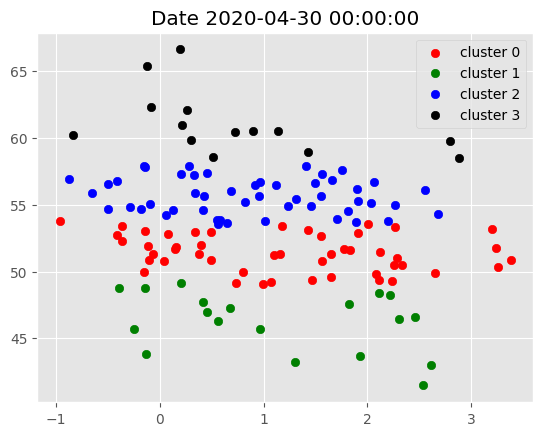

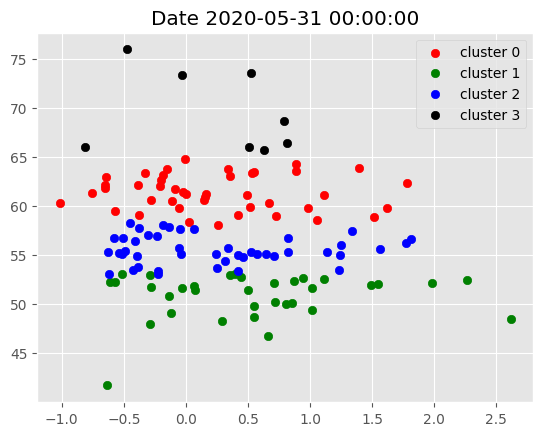

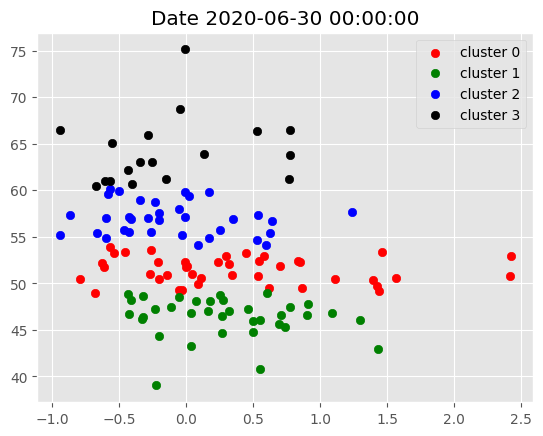

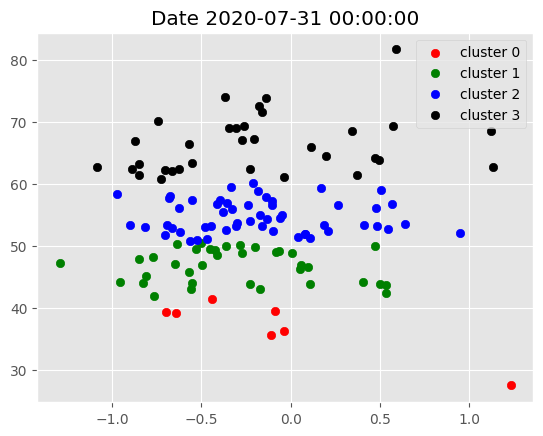

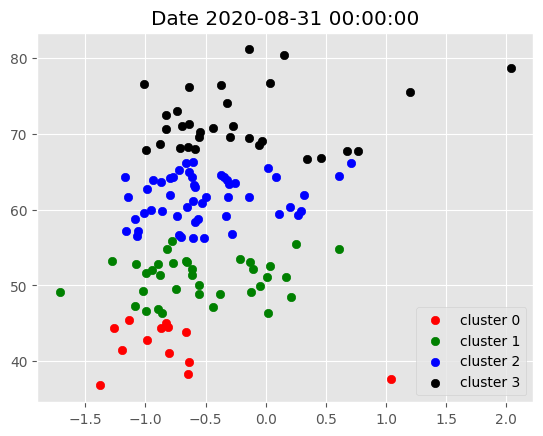

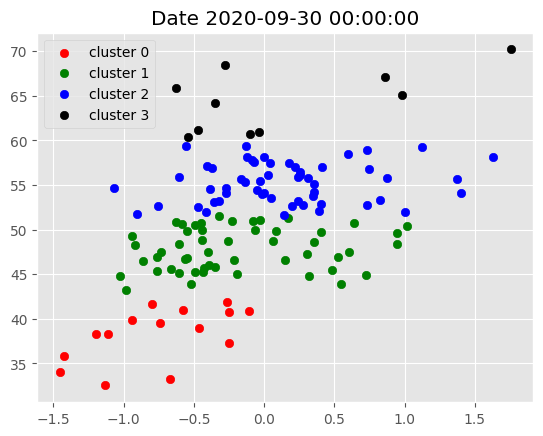

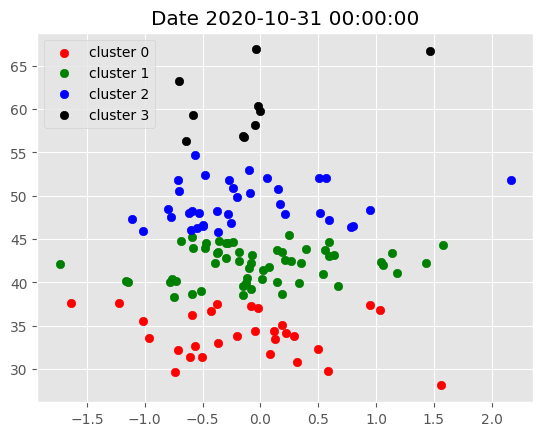

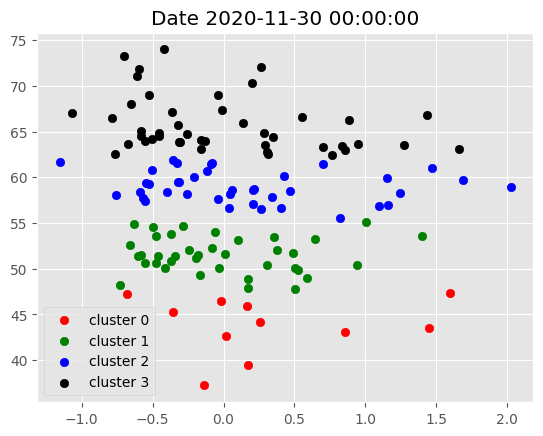

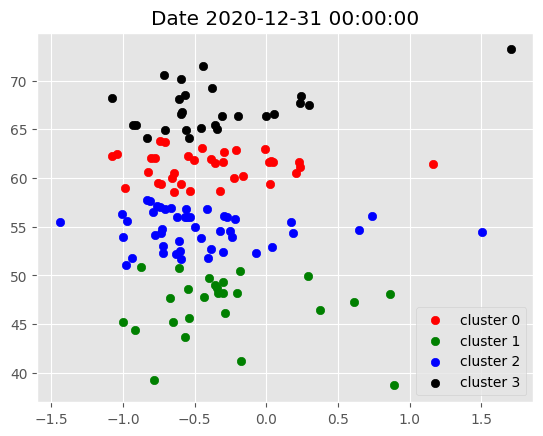

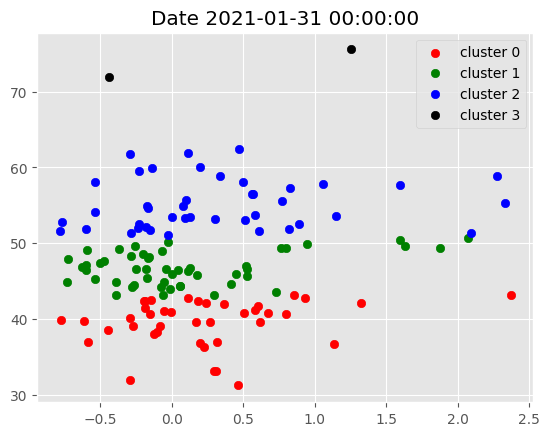

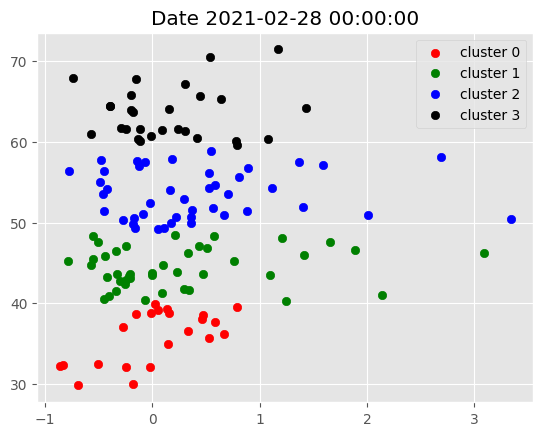

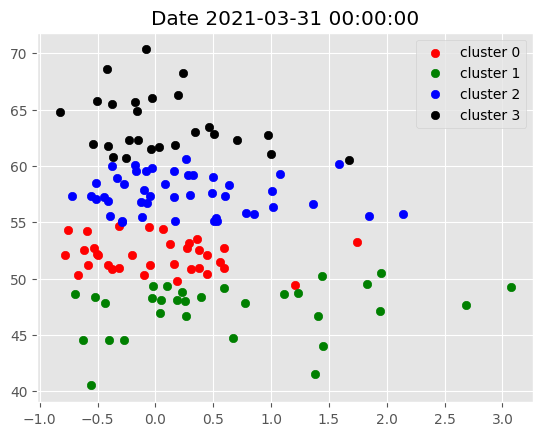

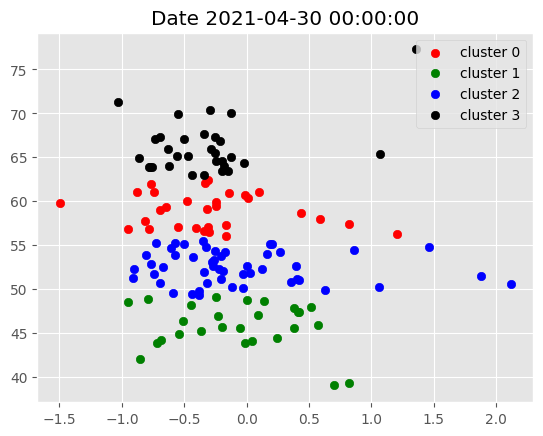

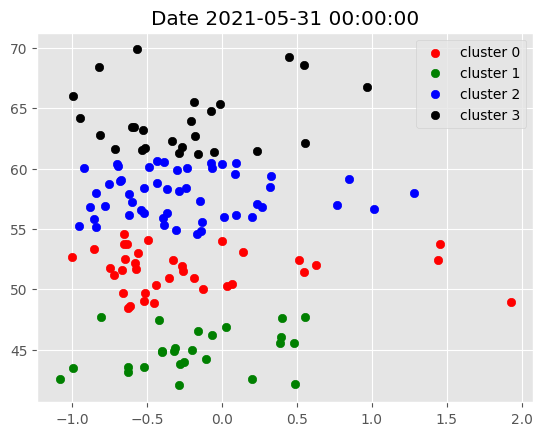

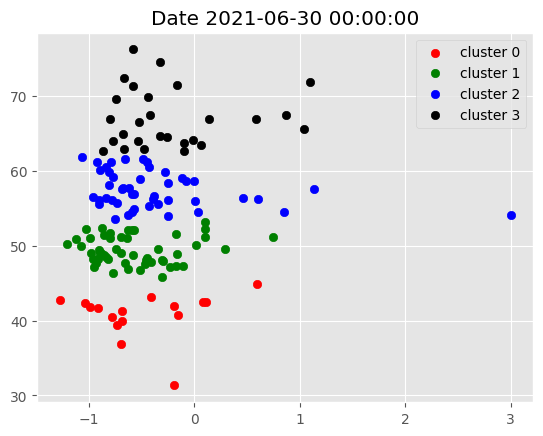

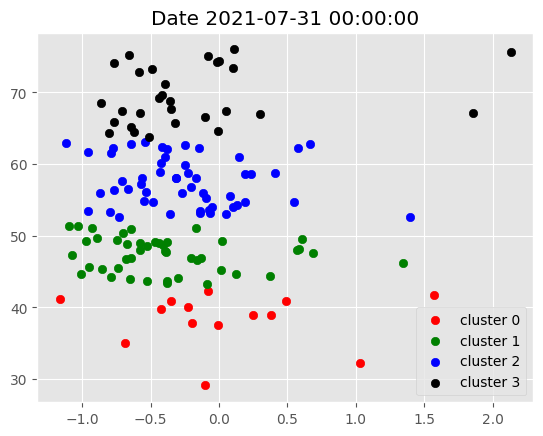

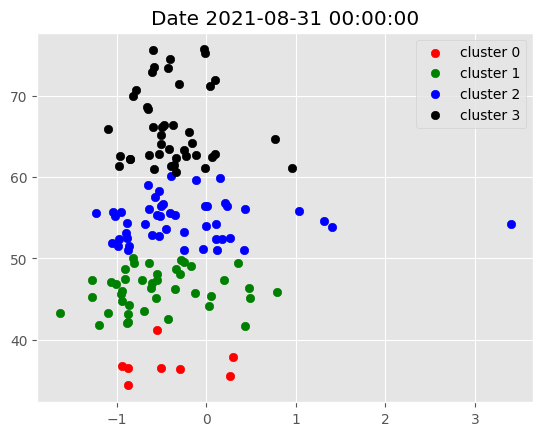

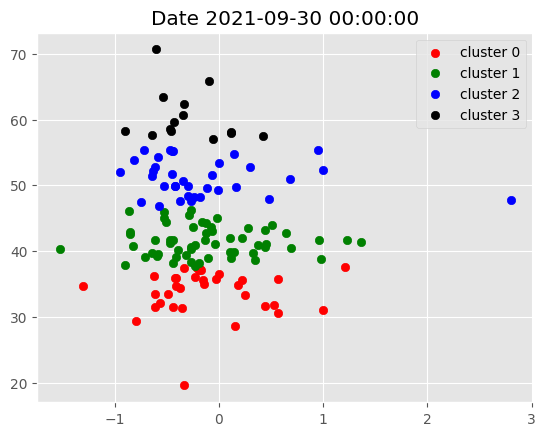

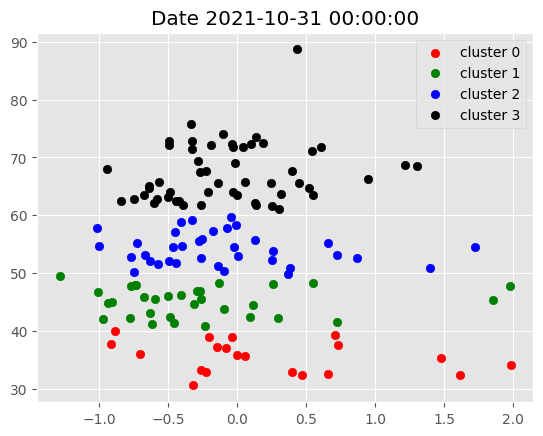

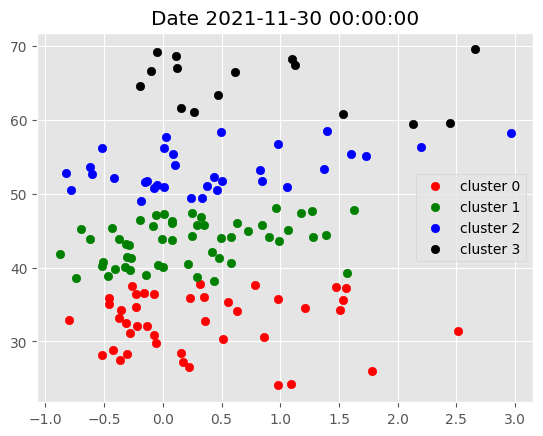

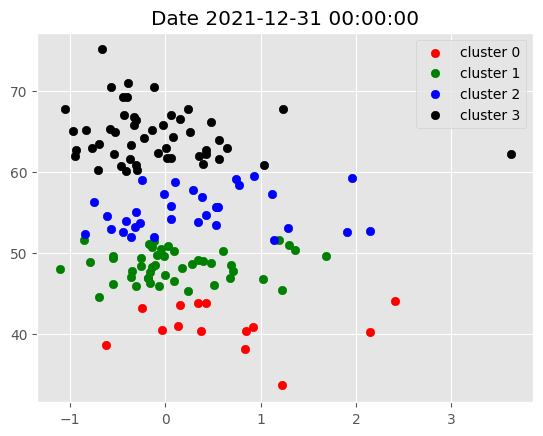

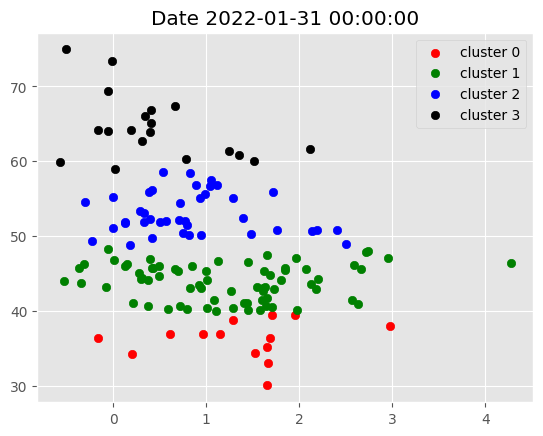

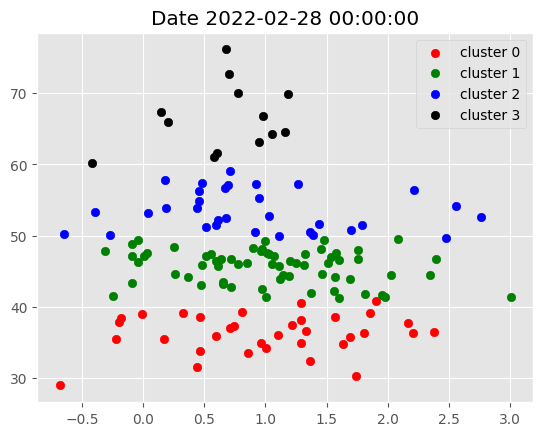

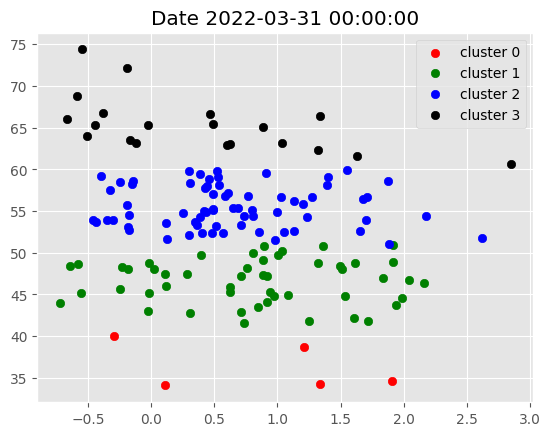

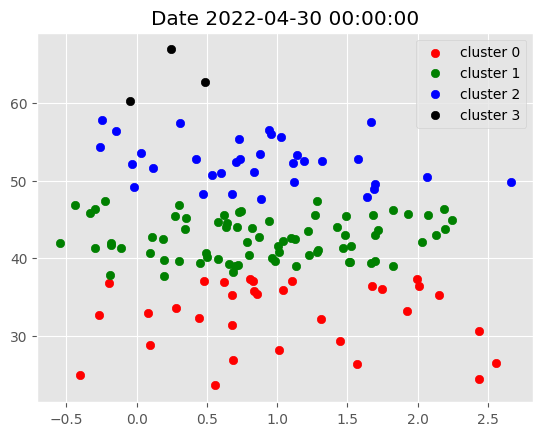

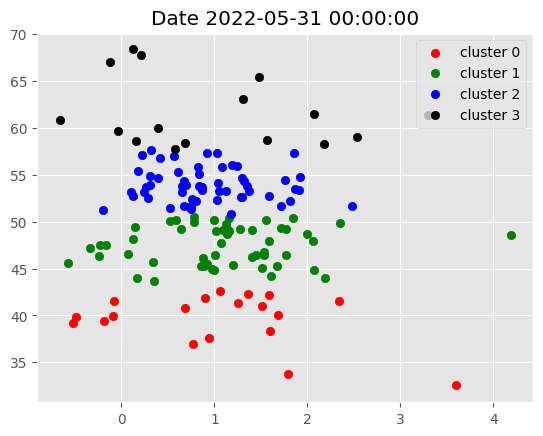

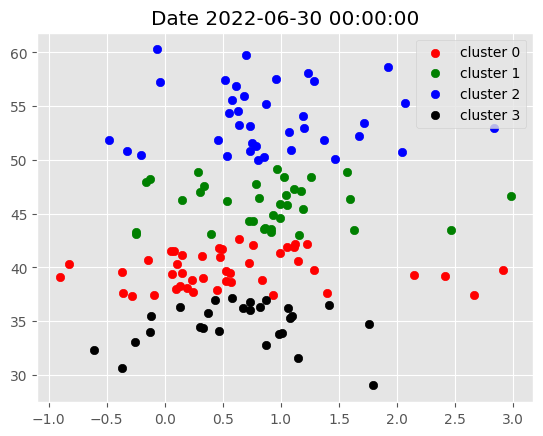

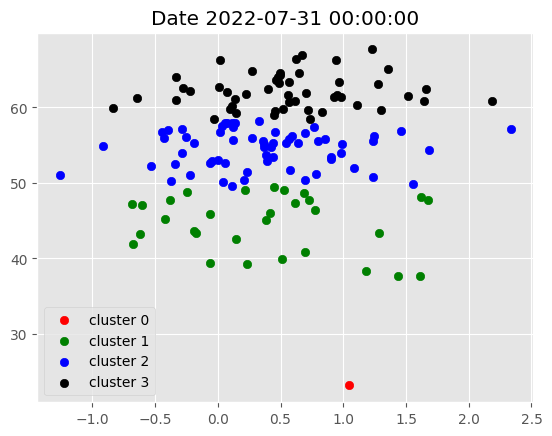

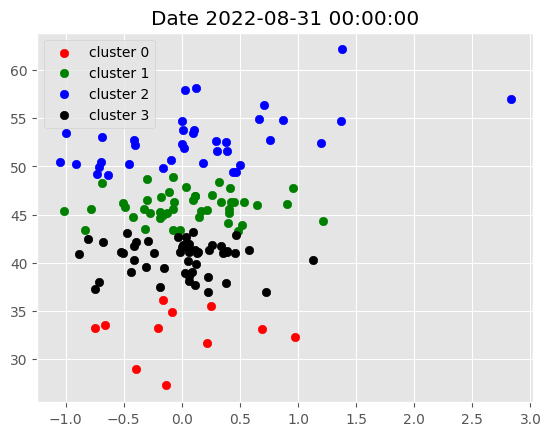

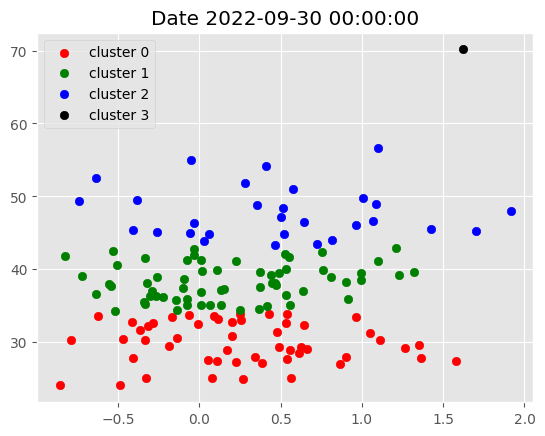

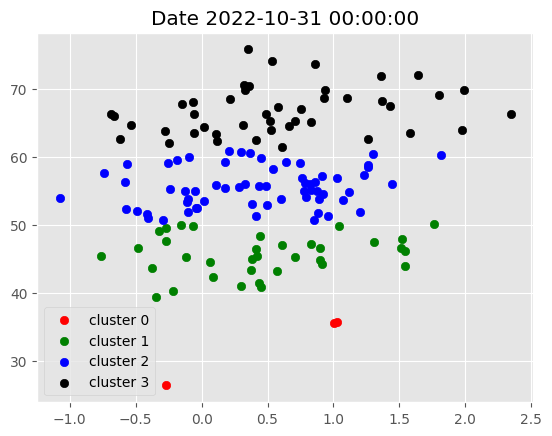

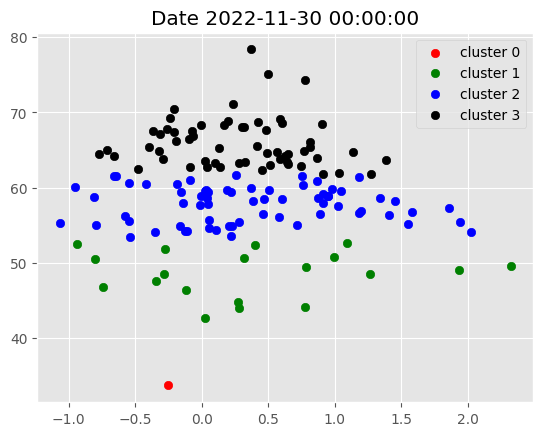

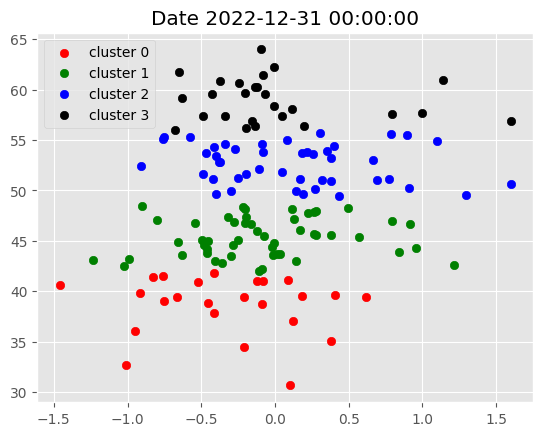

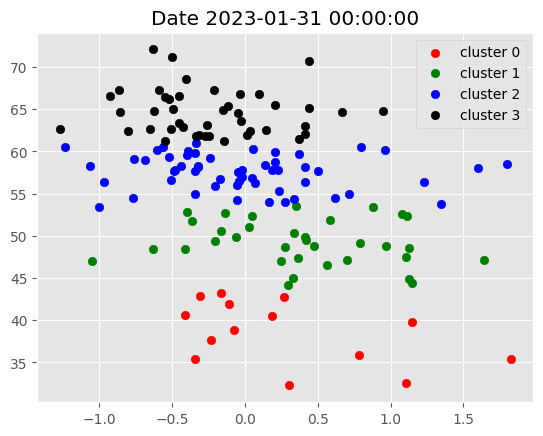

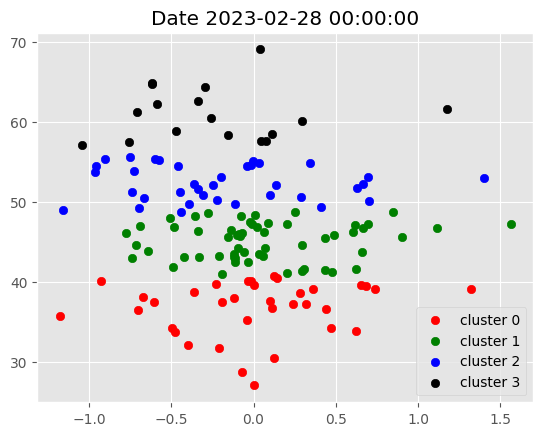

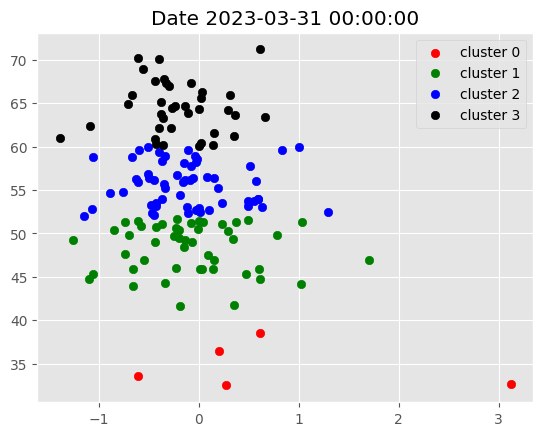

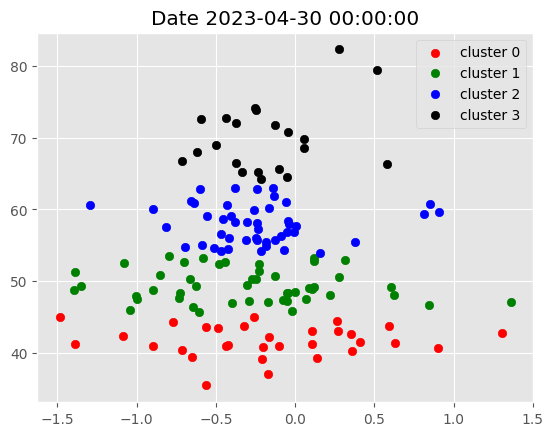

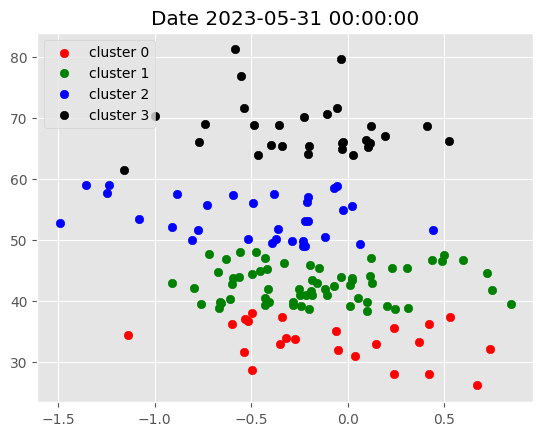

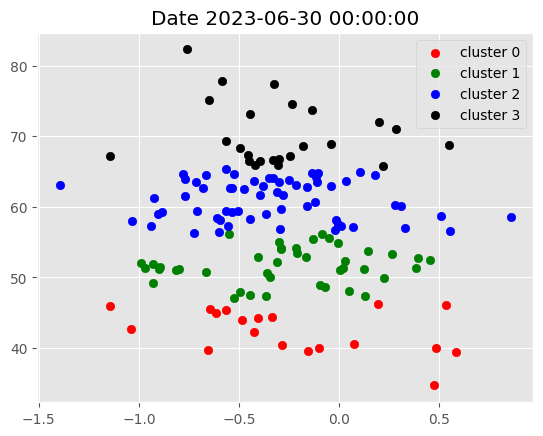

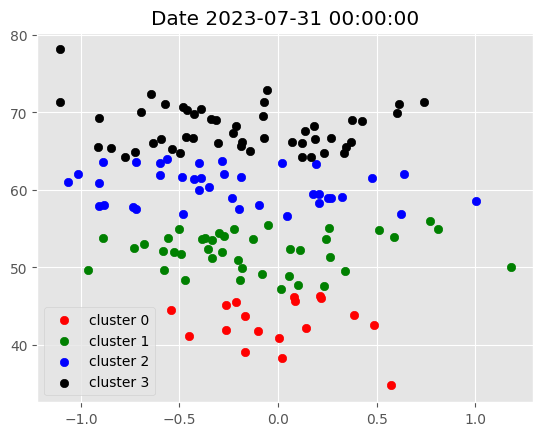

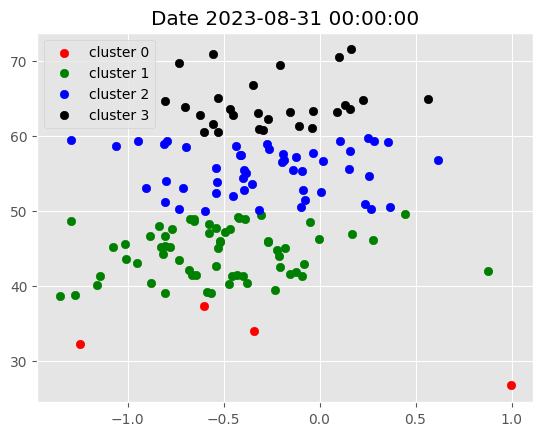

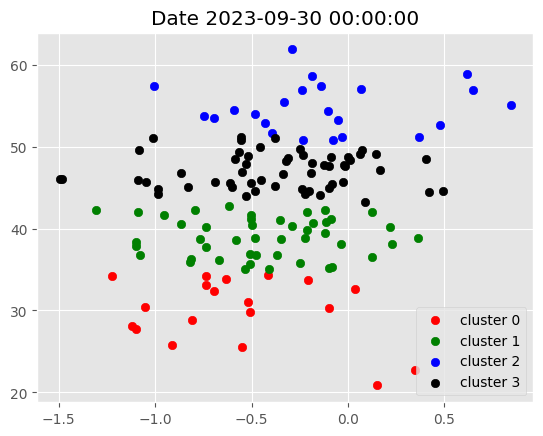

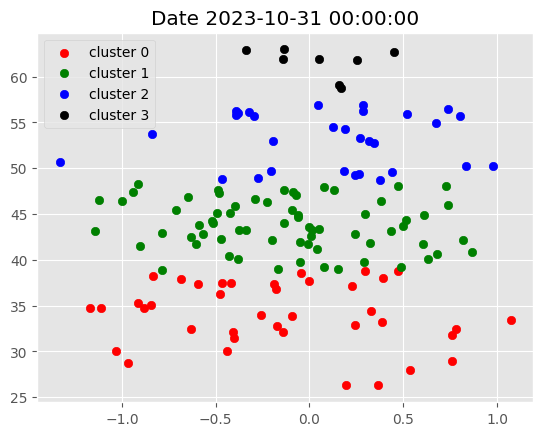

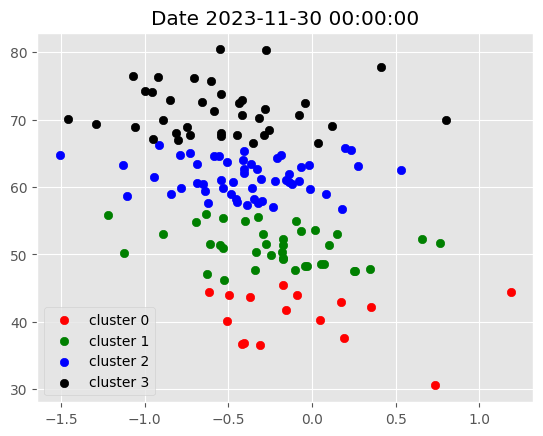

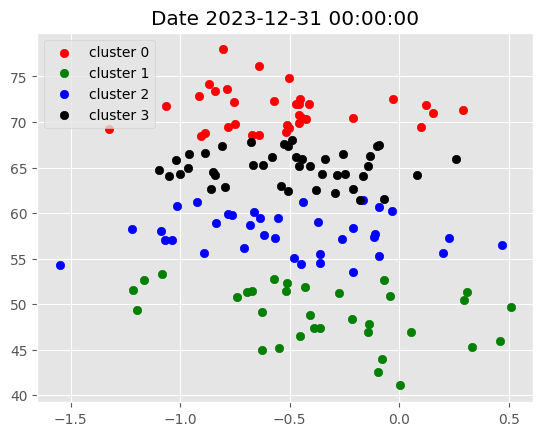

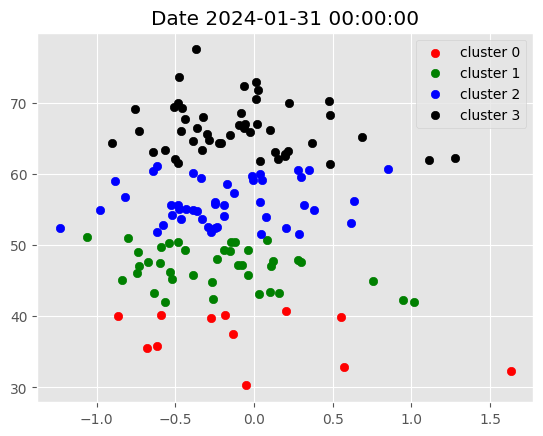

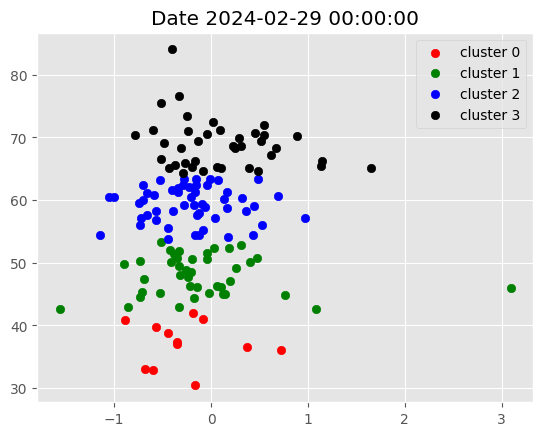

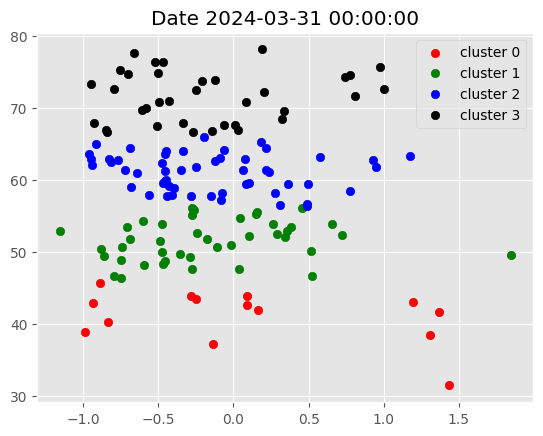

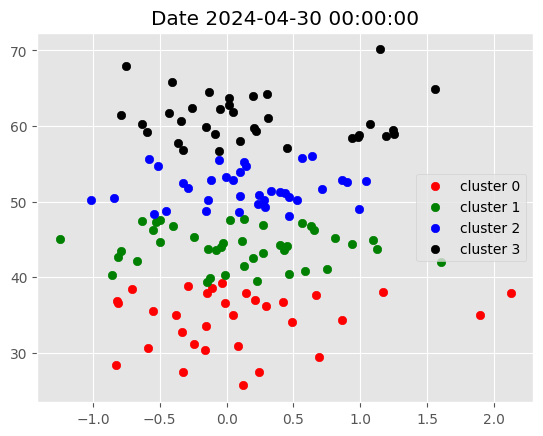

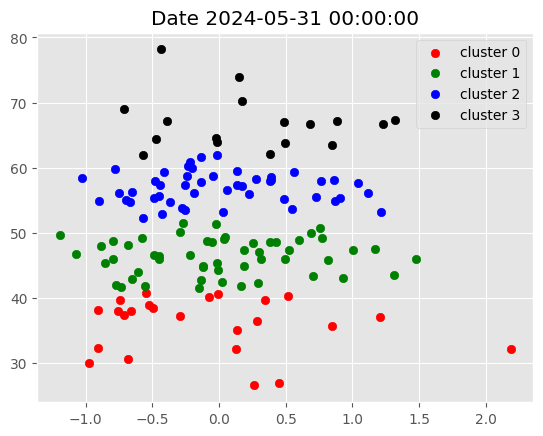

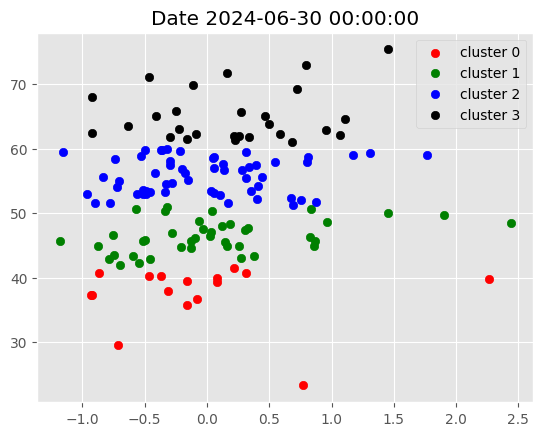

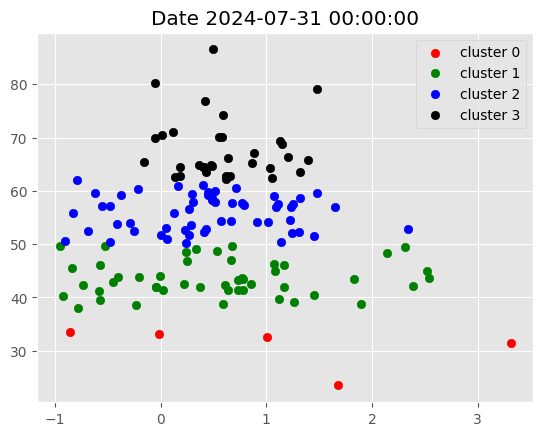

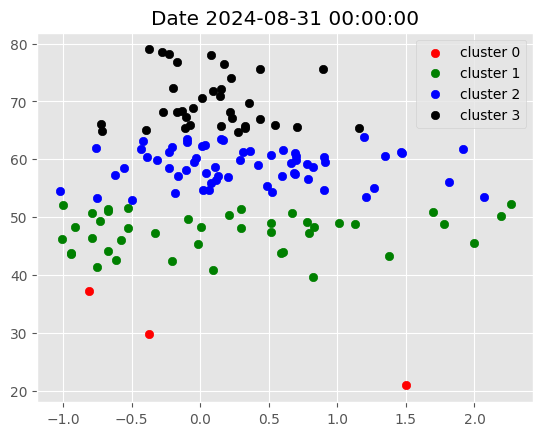

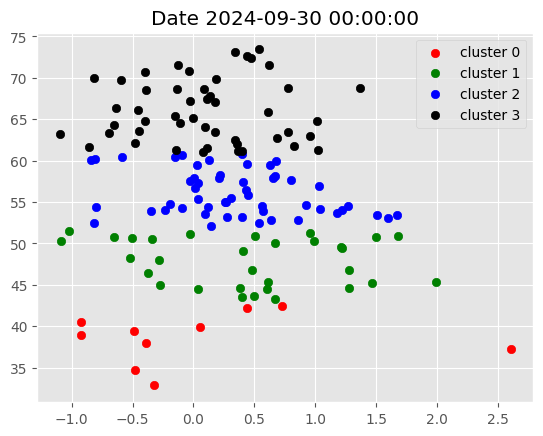

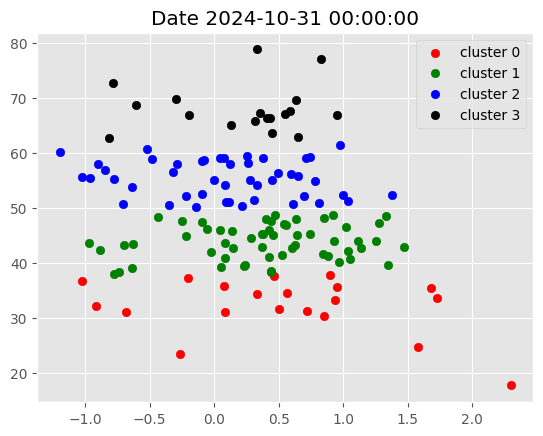

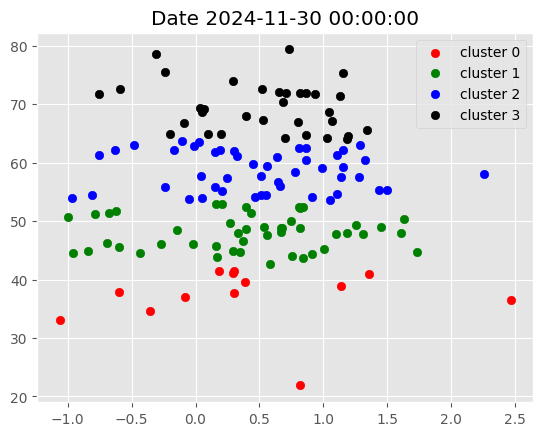

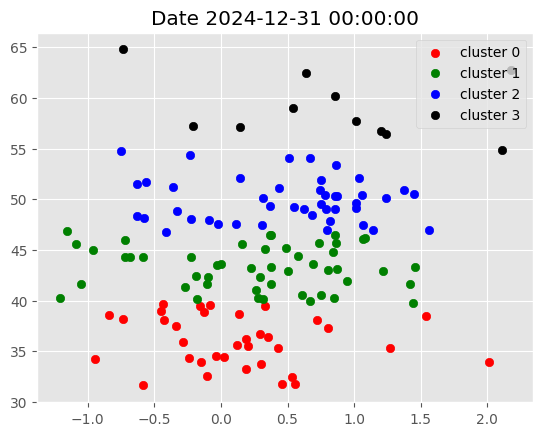

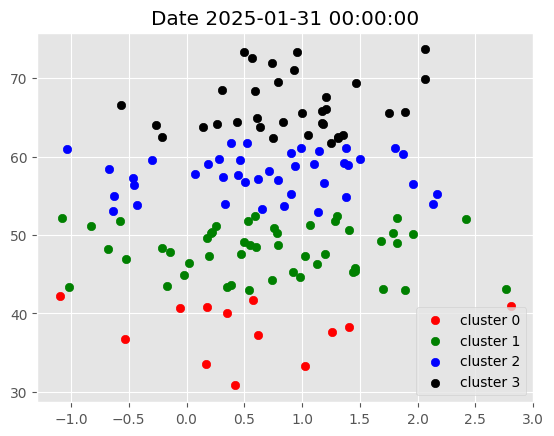

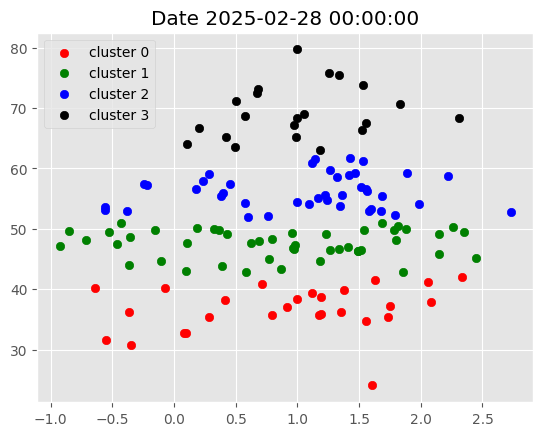

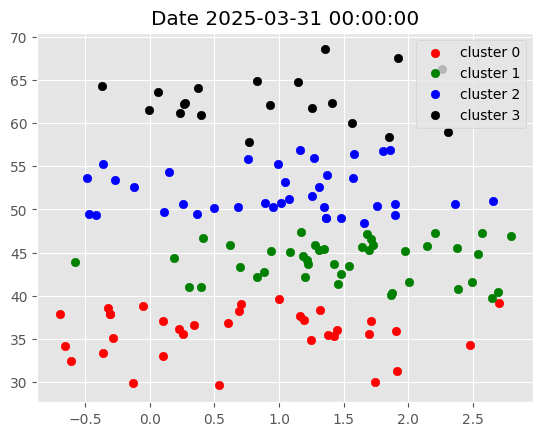

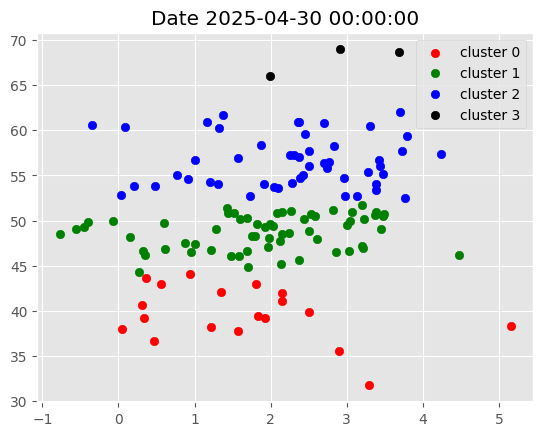

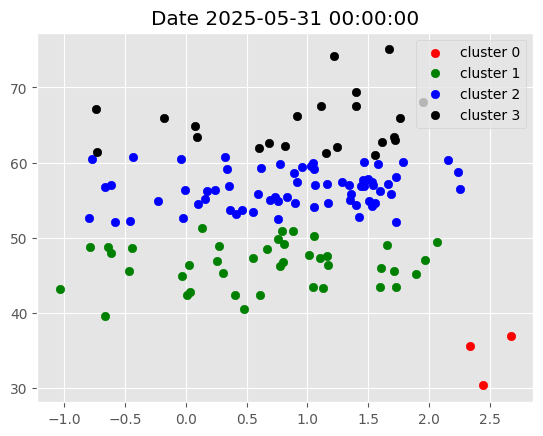

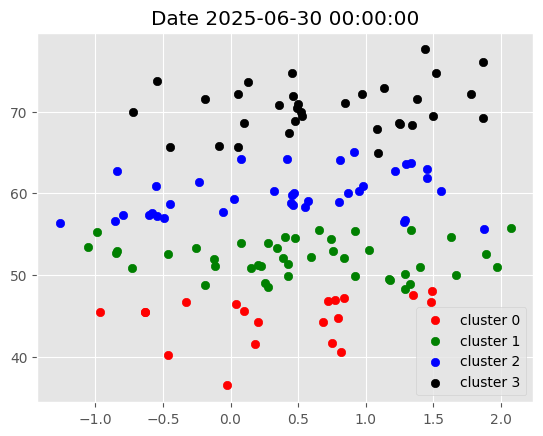

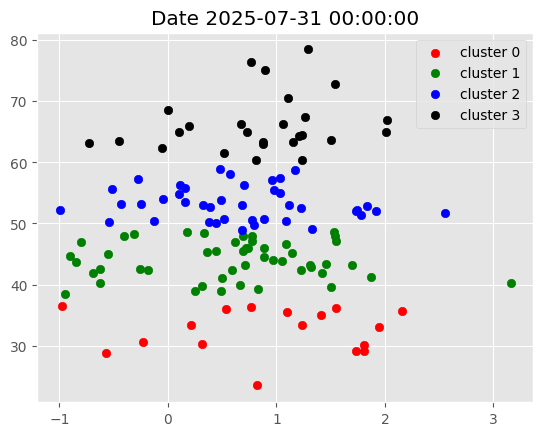

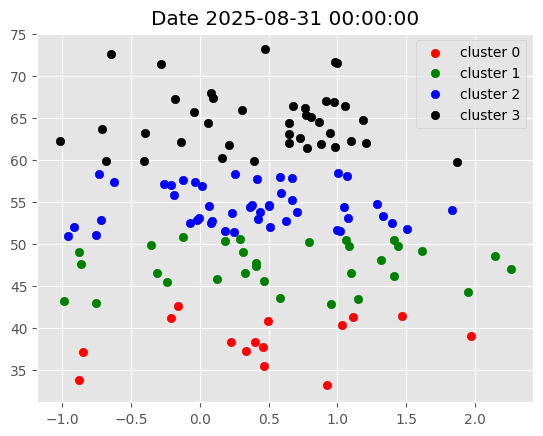

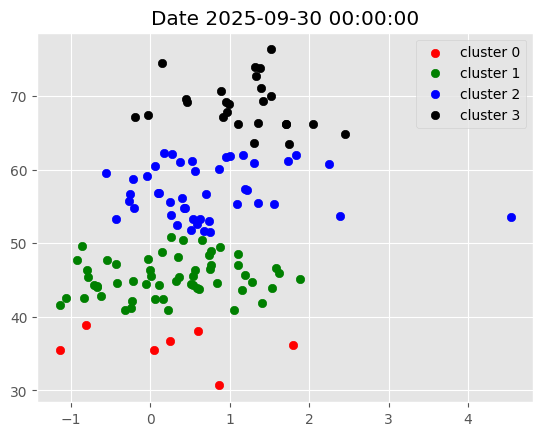

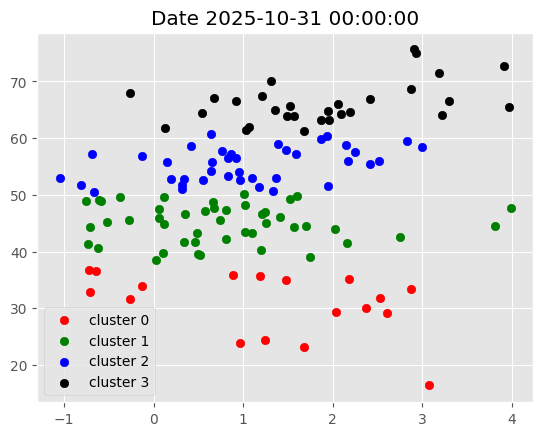

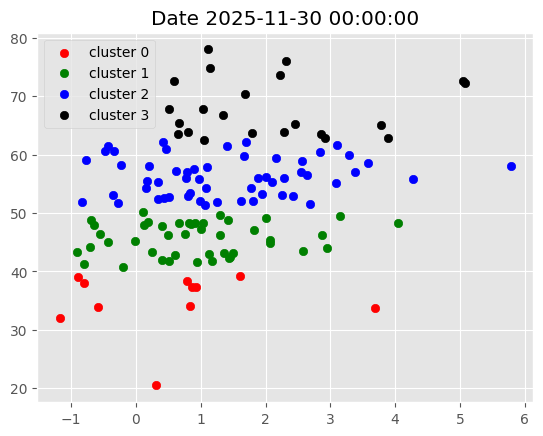

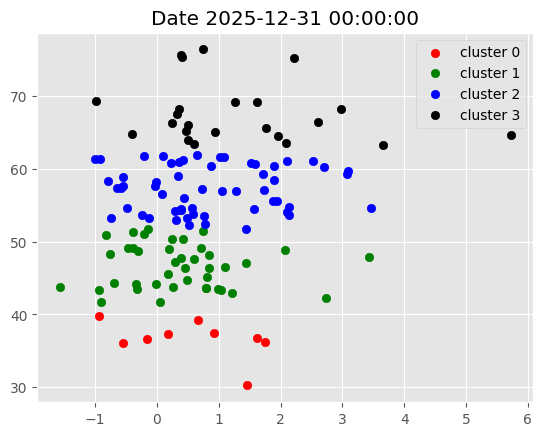

In [136]:
def plot_clusters(data): 
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')
    plot_clusters(g)

In [137]:
filtered_df = data[data['cluster'] == 3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2020-01-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMD',
  'AMGN',
  'BAC',
  'BMY',
  'C',
  'JNJ',
  'JPM',
  'LLY',
  'MAR',
  'MSFT',
  'NKE',
  'TSLA',
  'UNH',
  'WDC'],
 '2020-02-01': ['ADBE',
  'ADSK',
  'AMZN',
  'CHTR',
  'CRM',
  'IBM',
  'JNJ',
  'KO',
  'LLY',
  'LMT',
  'MCD',
  'MDLZ',
  'MSFT',
  'NEE',
  'NOW',
  'TSLA',
  'XYZ'],
 '2020-03-01': ['REGN', 'XYZ'],
 '2020-04-01': ['AXP',
  'BA',
  'BAC',
  'C',
  'CMCSA',
  'COP',
  'CVX',
  'DD',
  'DIS',
  'EBAY',
  'FCX',
  'GM',
  'GS',
  'JPM',
  'KO',
  'MS',
  'NXPI',
  'RTX',
  'T',
  'TGT',
  'VLO',
  'WDAY',
  'WDC',
  'WFC',
  'XOM'],
 '2020-05-01': ['AMGN',
  'AMZN',
  'CMG',
  'DD',
  'DHR',
  'EBAY',
  'GILD',
  'HUM',
  'META',
  'NOW',
  'PFE',
  'PYPL',
  'TSLA',
  'VLO'],
 '2020-06-01': ['ADSK', 'EBAY', 'LOW', 'LULU', 'PANW', 'PYPL', 'SPGI', 'WDAY'],
 '2020-07-01': ['AAPL',
  'ABBV',
  'ADBE',
  'ADSK',
  'AMZN',
  'DHR',
  'EA',
  'EBAY',
  'LOW',
  'LRCX',
  'LULU',
  'MSFT',
  'NVDA',
  'PYPL',
  'QCOM',
 

In [138]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)

    cov = risk_models.sample_cov(prices=prices, frequency=252)

    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, 0.1), solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

In [139]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks, start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12), end=data.index.get_level_values('date').unique()[-1])

new_df


[*********************100%***********************]  151 of 151 completed


Price            Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-12-31   37.496033   68.037056         NaN   63.996521  127.567726   
2019-01-02   37.538822   65.852562         NaN   61.492588  127.187790   
2019-01-03   33.799667   63.682800         NaN   58.590485  122.845345   
2019-01-04   35.242550   65.734451         NaN   60.262741  127.622055   
2019-01-07   35.164108   66.693878         NaN   61.165195  128.065308   
...                ...         ...         ...         ...         ...   
2025-12-23  272.359985  228.789993  136.490005  124.540001  270.769989   
2025-12-24  273.809998  229.889999  136.779999  124.809998  269.980011   
2025-12-26  273.399994  229.979996  136.820007  124.839996  271.089996   
2025-12-29  273.760010  230.839996  136.619995  124.570000  271.339996   
2025-12-30  273.079987  229.740005  136.910004  125.779999  270.000000   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-12-31  226.240005   75.509117  113.062164  128.610001  209.429993  ...   
2019-01-02  224.570007   75.588303  112.217117  128.960007  202.119995  ...   
2019-01-03  215.699997   71.022400  108.828354  121.849998  184.779999  ...   
2019-01-04  226.190002   72.746696  113.165634  128.279999  186.710007  ...   
2019-01-07  229.259995   73.204178  112.553398  132.720001  189.919998  ...   
...                ...         ...         ...         ...         ...  ...   
2025-12-23  352.420013  276.730011  257.010010  297.579987  156.759995  ...   
2025-12-24  352.980011  277.559998  258.100006  298.209991  157.839996  ...   
2025-12-26  353.799988  276.839996  258.839996  300.709991  158.369995  ...   
2025-12-29  353.160004  275.630005  259.609985  301.230011  157.839996  ...   
2025-12-30  352.510010  274.820007  259.529999  299.540009  158.139999  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ     WDAY       WDC       WFC       WMT   
Date                                                                            
2018-12-31  3817800  1375400  15331800  1379600   9208742  16544500  21017400   
2019-01-02  4271900  1465400  13969700  1796500   8447620  20295200  24458100   
2019-01-03  3300800  1690900  19245400  1828800  10233934  22262000  24831900   
2019-01-04  4364500  1874500  17035800  3077700   8378427  23343600  24087300   
2019-01-07  3833600  1294600  16349000  3294200   7895135  21858000  23369100   
...             ...      ...       ...      ...       ...       ...       ...   
2025-12-23  1970900   768500  19761800  2150400   3721100   8642100  20319900   
2025-12-24   881600   310200   7949500   766200   3067000   5506800   9009600   
2025-12-26  2517800   388100  11875400  1648600   3351600   5169400   9003800   
2025-12-29  2811600   628200  16846700  1612400   3906300   8624200  12979600   
2025-12-30  2569000   685900  15581300  1889800   6008000   6417800  11730600   

Price                                    
Ticker         WYNN       XOM       XYZ  
Date                                     
2018-12-31  2609800  15807000  13258800  
2019-01-02  4174400  16727200  13434000  
2019-01-03  2885100  13866100  19076300  
2019-01-04  3007200  16043600  30228600  
2019-01-07  3143800  10844200  18146900  
...             ...       ...       ...  
2025-12-23  1096700  12567600   5068200  
2025-12-24   615000   6137400   3017700  
2025-12-26   717300   8066100   3118400  
2025-12-29  1017200  14782500   4216700  
2025-12-30   689900  11150500   2958800  

[1760 rows x 755 columns]

In [140]:
# Verificar estructura de columnas
print("Tipo de columnas:", type(new_df.columns))
print("Columnas:", new_df.columns[:5])
print("\nPrimeras filas:")
new_df.head()

Tipo de columnas: <class 'pandas.core.indexes.multi.MultiIndex'>
Columnas: MultiIndex([('Close', 'AAPL'),
            ('Close', 'ABBV'),
            ('Close', 'ABNB'),
            ('Close',  'ABT'),
            ('Close',  'ACN')],
           names=['Price', 'Ticker'])

Primeras filas:


Price           Close                                                     \
Ticker           AAPL       ABBV ABNB        ABT         ACN        ADBE   
Date                                                                       
2018-12-31  37.496033  68.037056  NaN  63.996521  127.567726  226.240005   
2019-01-02  37.538822  65.852562  NaN  61.492588  127.187790  224.570007   
2019-01-03  33.799667  63.682800  NaN  58.590485  122.845345  215.699997   
2019-01-04  35.242550  65.734451  NaN  60.262741  127.622055  226.190002   
2019-01-07  35.164108  66.693878  NaN  61.165195  128.065308  229.259995   

Price                                                      ...   Volume  \
Ticker            ADI         ADP        ADSK        ALGN  ...      VLO   
Date                                                       ...            
2018-12-31  75.509117  113.062164  128.610001  209.429993  ...  3817800   
2019-01-02  75.588303  112.217117  128.960007  202.119995  ...  4271900   
2019-01-03  71.022400  108.828354  121.849998  184.779999  ...  3300800   
2019-01-04  72.746696  113.165634  128.279999  186.710007  ...  4364500   
2019-01-07  73.204178  112.553398  132.720001  189.919998  ...  3833600   

Price                                                                          \
Ticker         VRTX        VZ     WDAY       WDC       WFC       WMT     WYNN   
Date                                                                            
2018-12-31  1375400  15331800  1379600   9208742  16544500  21017400  2609800   
2019-01-02  1465400  13969700  1796500   8447620  20295200  24458100  4174400   
2019-01-03  1690900  19245400  1828800  10233934  22262000  24831900  2885100   
2019-01-04  1874500  17035800  3077700   8378427  23343600  24087300  3007200   
2019-01-07  1294600  16349000  3294200   7895135  21858000  23369100  3143800   

Price                           
Ticker           XOM       XYZ  
Date                            
2018-12-31  15807000  13258800  
2019-01-02  16727200  13434000  
2019-01-03  13866100  19076300  
2019-01-04  16043600  30228600  
2019-01-07  10844200  18146900  

[5 rows x 755 columns]

In [141]:
# Acceder a las columnas Close correctamente
try:
    returns_dataframe = np.log(new_df['Close']).diff()
except KeyError:
    # Si falla, intentar con Adj Close o reconstruir
    if 'Adj Close' in new_df.columns:
        returns_dataframe = np.log(new_df['Adj Close']).diff()
    else:
        # Intentar acceder al primer nivel
        returns_dataframe = np.log(new_df.xs('Close', level=0, axis=1)).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        try:
            optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Close'][cols]
        except (KeyError, TypeError):
            if 'Adj Close' in new_df.columns:
                optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]
            else:
                optimization_df = new_df.xs('Close', level=0, axis=1).loc[optimization_start_date:optimization_end_date, cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 4))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f"Optimization failed for date {start_date}")

        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), left_index=True, right_index=True)\
            .reset_index()
        
        # El orden correcto después de reset_index es: ticker (índice), fecha (level=0)
        temp_df.columns = ['ticker', 'date', 'return', 'weight']
        
        temp_df = temp_df.set_index(['date', 'ticker'])

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(f'{e}')

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Optimization failed for date 2020-03-01
Optimization failed for date 2020-04-01
Optimization failed for date 2020-06-01
Optimization failed for date 2021-02-01
Optimization failed for date 2022-05-01
Optimization failed for date 2022-07-01
Optimization failed for date 2022-09-01
Optimization failed for date 2022-10-01
Optimization failed for date 2023-11-01
Optimization failed for date 2025-05-01


,Strategy Return
date,
2020-01-02,0.015138
2020-01-03,-0.008977
2020-01-06,0.000557
2020-01-07,-0.003709
2020-01-08,0.007430
...,...
2025-12-23,0.003650
2025-12-24,0.003549
2025-12-26,-0.000766


In [142]:
spy = yf.download(tickers='SPY', start=portfolio_df.index.unique()[0], end=portfolio_df.index.unique()[-1])

spy_ret = np.log(spy[['Close']]).diff().dropna().rename({'Close': 'SPY Return'}, axis=1)

# Flatten spy_ret columns if it's a MultiIndex
if isinstance(spy_ret.columns, pd.MultiIndex):
	spy_ret.columns = spy_ret.columns.droplevel(1)

# Ensure spy_ret index is a simple DatetimeIndex
if isinstance(spy_ret.index, pd.MultiIndex):
	spy_ret.index = spy_ret.index.droplevel(1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Return
2020-01-03,-0.008977,-0.007601
2020-01-06,0.000557,0.003808
2020-01-07,-0.003709,-0.002816
2020-01-08,0.007430,0.005315
2020-01-09,0.008360,0.006758
...,...,...
2025-12-22,0.006829,0.006211
2025-12-23,0.003650,0.004560
2025-12-24,0.003549,0.003511
2025-12-26,-0.000766,-0.000101


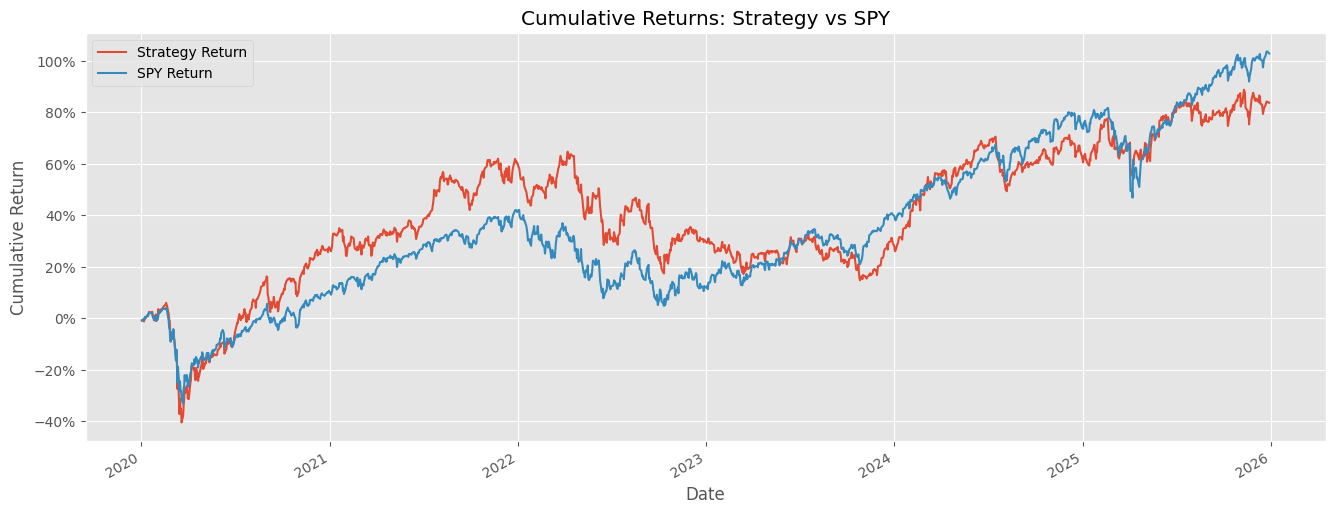

In [143]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2025-12-29'].plot(figsize=(16, 6), title='Cumulative Returns: Strategy vs SPY', ylabel='Cumulative Return', xlabel='Date')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()